In [13]:
from SBM_attributed import *
from BregmanFramework import *
from bregman_kmeans import *
from sklearn.metrics import rand_score, calinski_harabasz_score, mutual_info_score, accuracy_score
import torch
import matplotlib.pyplot as plt
from torch_geometric.utils import *
from torch import Tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [14]:
c = 3
n = 100
N = c*n
delta = 10
d = 2
dim = c*d
P = np.array([[0.8, 0.2, 0.3],[0.2, 0.7, 0.4],[0.3, 0.4, 0.6]])
true_labels = [0]*n + [1]*n + [2]*n

In [15]:
## GNN propriamente dita
class GCN(torch.nn.Module):
    def __init__(self,n_feat):
        super().__init__()
        self.conv1 = GCNConv(n_feat, 2)
        #self.mlp = torch.nn.Linear(10,size)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #x = self.mlp(x)
        return x

In [16]:
classifier = BregmanClustering(norm=-2,matrix_norm=False,
                               data_divergence_method="Nelementwise")

In [17]:
def loss_fn(X):
    X_ = X.detach().numpy()
    bk = BregmanKmeans(divergence_method="euclidean")
    W,mu= bk.hard_clustering(X_,c,5)
    W = torch.tensor(W)
    mu = torch.tensor(mu)
    sum_=classifier.data_divergence(X,W,mu).sum()
    return sum_

In [18]:
## Treino da GNN
def train_model(model,graph_data,epochs=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    out = total = 0
    graph_data.x = Tensor.float(graph_data.x)
    model.train()
    while total < epochs:
        optimizer.zero_grad()
        out = model(graph_data)
        loss = loss_fn(out)
        loss.backward()
        optimizer.step()
        total += 1

In [19]:
## Obtem a representação da GNN da penúltima camada
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [29]:
pin = 0.1
p_out = 0.01
sigma = 1
P_net = np.eye(c)*pin
P_net[P_net==0] = p_out
G,A,X = generate_benchmark_unit_circle(P_net,c,sigma,n,dim,delta=10)
graph_data = from_networkx(G,group_node_attrs=['attr'])
#_,A,X = generate_benchmark(P,c,delta=0,n=n,dim=d,sample_along_direction=True,P_data=P)

In [30]:
model = GCN(graph_data.num_node_features)
train_model(model,graph_data,epochs=1000)    
model.conv1.register_forward_hook(get_activation('conv1'))
out = model(graph_data)
X_t = F.relu(activation["conv1"]).detach().numpy()

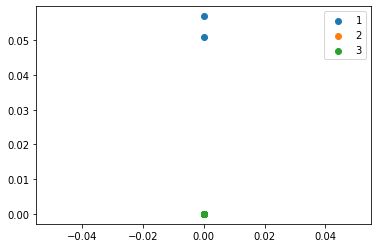

In [31]:
plt.scatter(X_t[:n,0],X_t[:n,1],label="1")
plt.scatter(X_t[n:2*n,0],X_t[n:2*n,1],label="2")
plt.scatter(X_t[2*n:3*n,0],X_t[2*n:3*n,1],label="3")
plt.legend()

In [32]:
X_t

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.05087817],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.

## Soft

In [ ]:
bk = BregmanKmeans(divergence_method="euclidean")
W,mu = bk.soft_clustering(X,3,5)

In [ ]:
pred_labels = np.argmax(W, axis=1)
true_labels = [0]*n + [1]*n + [2]*n
print(rand_score(true_labels, pred_labels),mutual_info_score(true_labels, pred_labels))

In [ ]:
mu

## Hard

In [ ]:
W,mu = bk.hard_clustering(X,3,5)
pred_labels = np.argmax(W, axis=1)
print(rand_score(true_labels, pred_labels),mutual_info_score(true_labels, pred_labels))

In [ ]:
mu

## Kmeans

In [ ]:
from sklearn.cluster import KMeans
classifier = KMeans(n_clusters=3)

In [ ]:
pred_labels = classifier.fit_predict(X)
true_labels = [0]*n + [1]*n + [2]*n
print(rand_score(true_labels, pred_labels),mutual_info_score(true_labels, pred_labels))

In [ ]:
classifier.cluster_centers_